https://www.kaggle.com/uciml/electric-power-consumption-data-set

### Difinição do Problema

Uma empresa de energia quer saber quanto de energia terá que ser produzida no proximo no mês de dezembro de 2010 para atender seus clientes.

## Análise dos Dados

Como o dataset está dividido
* Date: dd/mm/aaaa
* Hora: hh:mm:ss
* Global_active_power: potência média por minuto
* Global_reactive_power: potência média por minuto doméstico
* Voltage: tensão por minuto
* Global_intesity: intensidade da corrente média por minuto
* Sub_meteting_1: submedição de energia 1 - Corresponde a cozinha
* Sub_meteting_2: submedição de energia 2 - Corresponde a lavanderia
* Sub_meteting_3: submedição de energia 3 - Corresponte a aquecedor e ar condicionado

Temos dados do ano de dezembro de 2006 até o ano de novembro de 2010. A coluna Global_active_power que vai ser previst.

In [1]:
# Manipulação dos dados
import numpy as np
import pandas as pd
from datetime import datetime

# Manipulação dos modelos
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet

# Métricas
from sklearn.metrics import mean_squared_error

# Visualização
import matplotlib.pyplot as plt
import matplotlib as m
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 18
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
m.rcParams['figure.figsize'] = 18, 10

# Error
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

In [2]:
data = pd.read_csv('household_power_consumption.txt',
               sep=';',parse_dates={'data_hora' : ['Date', 'Time']}, infer_datetime_format=True, low_memory=False,
                na_values=['nan','?'])

In [3]:
data.head()

,data_hora,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 8 columns):
data_hora                datetime64[ns]
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 126.7 MB


In [5]:
# Separando as datas por: ano, mês, dia, hora e dia da semana
data['ano'] = data['data_hora'].dt.year
data['mes'] = data['data_hora'].dt.month
data['dia'] = data['data_hora'].dt.day
data['hora'] = data['data_hora'].dt.hour
data['dia_semana'] = data['data_hora'].dt.dayofweek

In [6]:
# Descobrindo se o dia é final da semana
def fds(data):
    if data.dayofweek == 5 or data.dayofweek == 6:
        return 1
    else:
        return 0

In [7]:
data['final_semana'] = data['data_hora'].apply(fds)

In [8]:
data = data.set_index('data_hora')

In [9]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,ano,mes,dia,hora,dia_semana,final_semana
data_hora,,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006,12,16,17,5,1
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006,12,16,17,5,1
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006,12,16,17,5,1
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006,12,16,17,5,1
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006,12,16,17,5,1


In [10]:
data.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
ano                          0
mes                          0
dia                          0
hora                         0
dia_semana                   0
final_semana                 0
dtype: int64

## Visualização dos dados

In [11]:
data.columns = map(str.lower, data.columns)

### Observando a distribuição dos valores

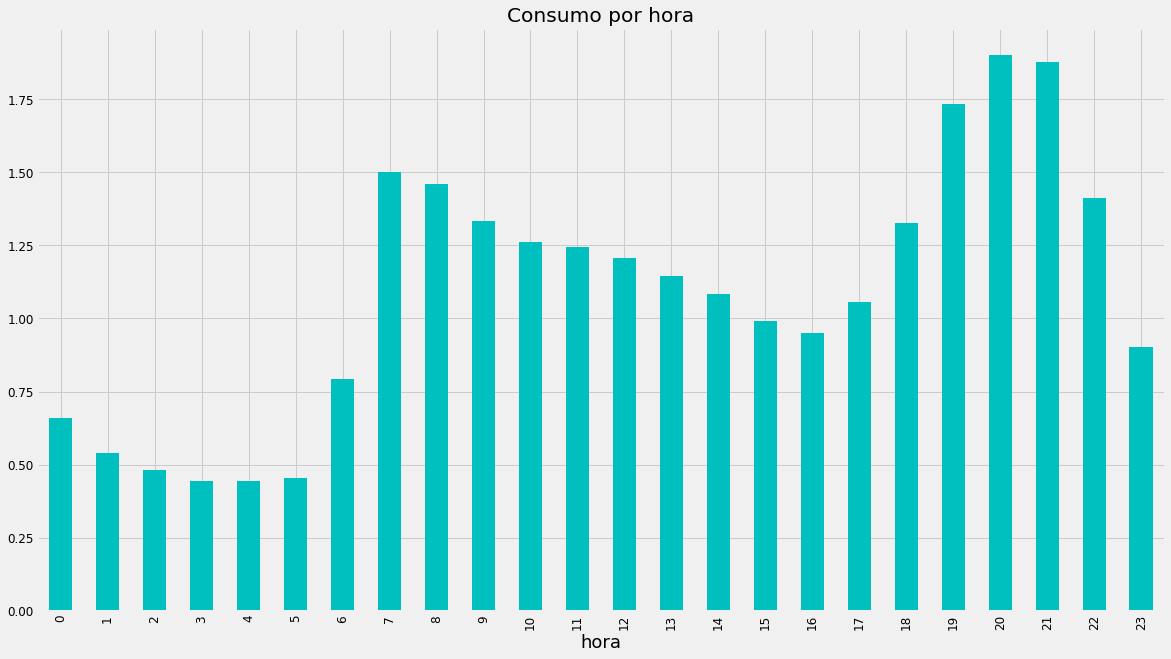

In [12]:
# Buscando pelo horario que mais se consome energia
data.groupby('hora')['global_active_power'].mean().plot.bar(color='c',title='Consumo por hora')

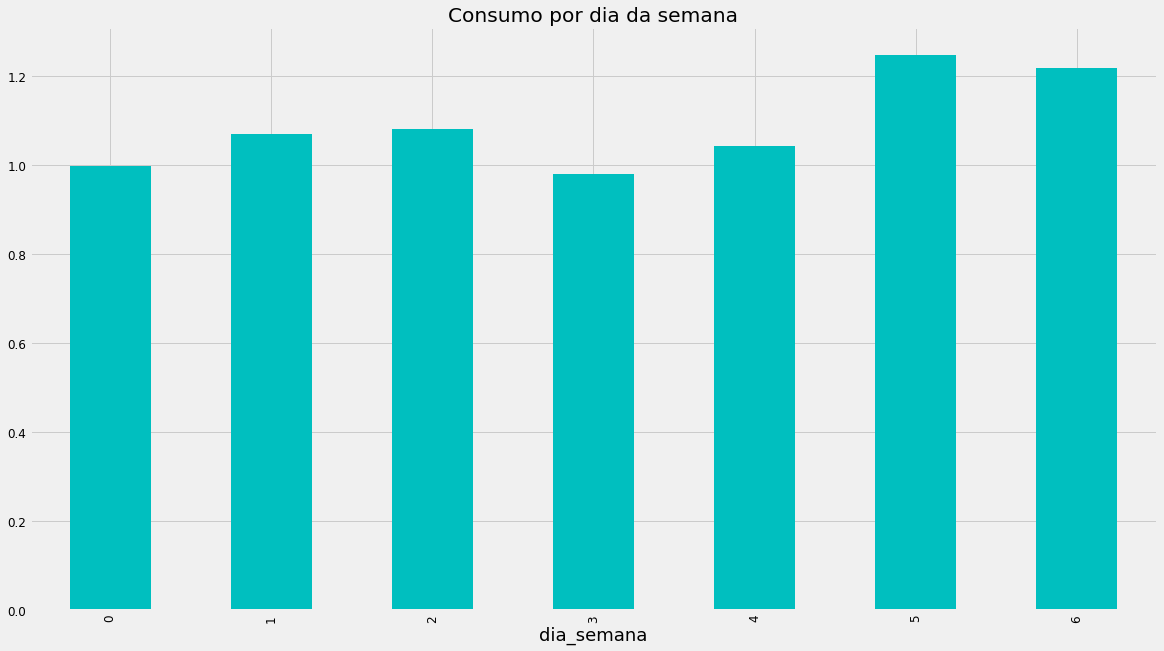

In [13]:
data.groupby('dia_semana')['global_active_power'].mean().plot.bar(color='c',title='Consumo por dia da semana')

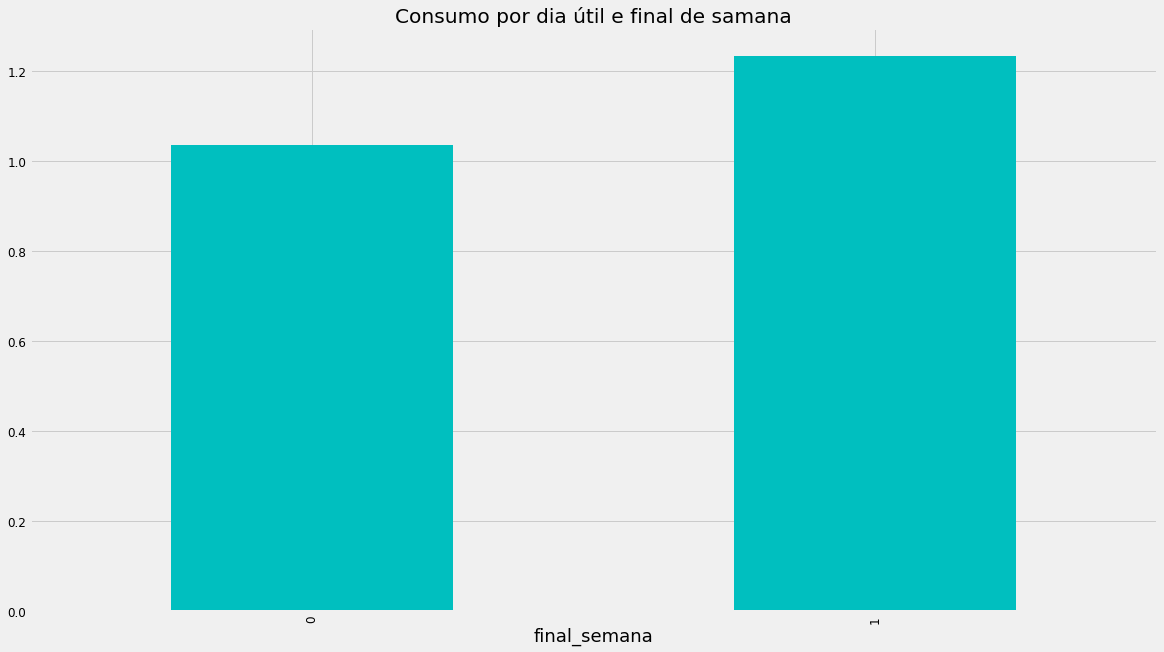

In [14]:
# Buscando pelo consumo entre final de semana e dias úteis
data.groupby('final_semana')['global_active_power'].mean().plot.bar(
    color='c', title='Consumo por dia útil e final de samana')

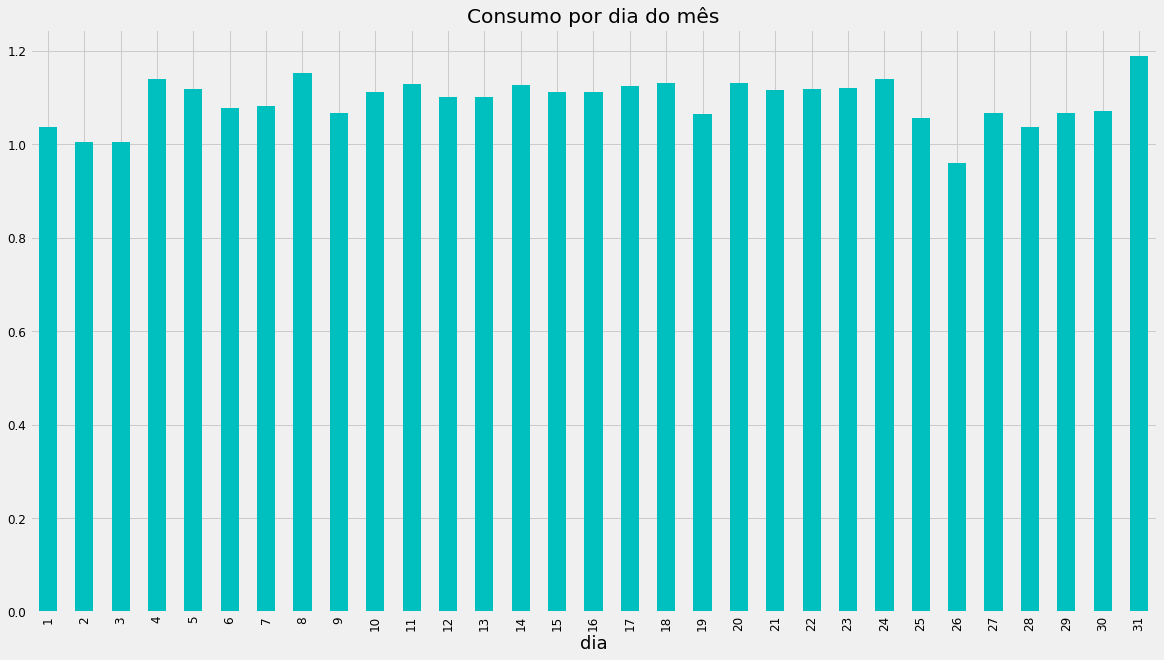

In [15]:
# Buscando pelo dia do mês que mais se consome energia
data.groupby('dia')['global_active_power'].mean().plot.bar(color='c', title='Consumo por dia do mês')

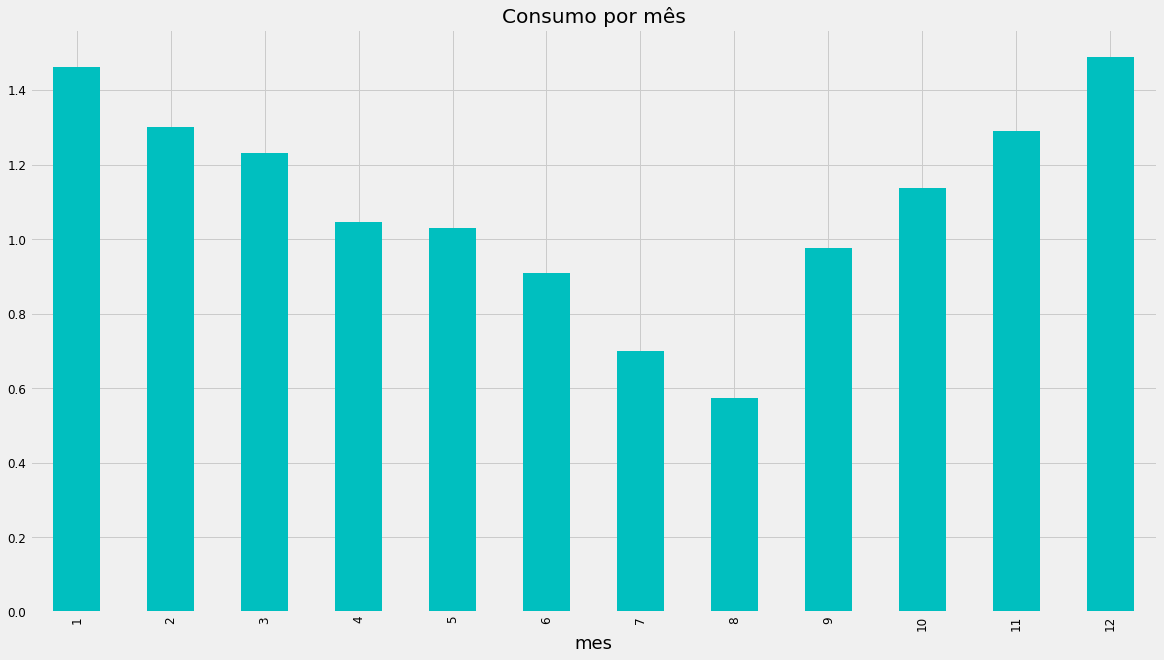

In [16]:
# Buscando pelo mês que mais se consome energia
data.groupby('mes')['global_active_power'].mean().plot.bar(color='c', title='Consumo por mês')

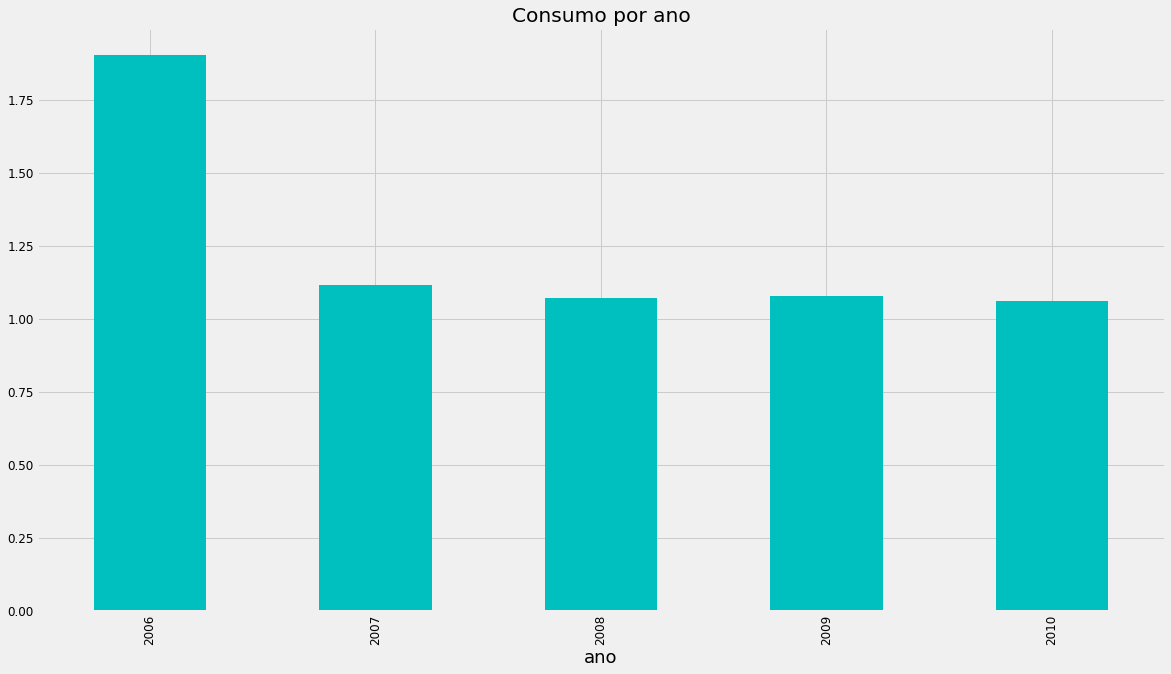

In [17]:
data.groupby('ano')['global_active_power'].mean().plot.bar(color='c', title='Consumo por ano')

In [18]:
# Reamostrando os dados 

# Série Temporal média por hora
media_hor = data.global_active_power.resample('H').mean()
#media_hor.dropna(inplace=True)

# Série Temporal média por dia
media_dia = data.global_active_power.resample('D').mean()
#media_dia.dropna(inplace=True)

# Série Temporal média por semana
media_sem =  data.global_active_power.resample('W').mean()
#media_sem.dropna(inplace=True)

# Série Temporal média mês
media_mes = data.global_active_power.resample('M').mean()
#media_mes.dropna(inplace=True)

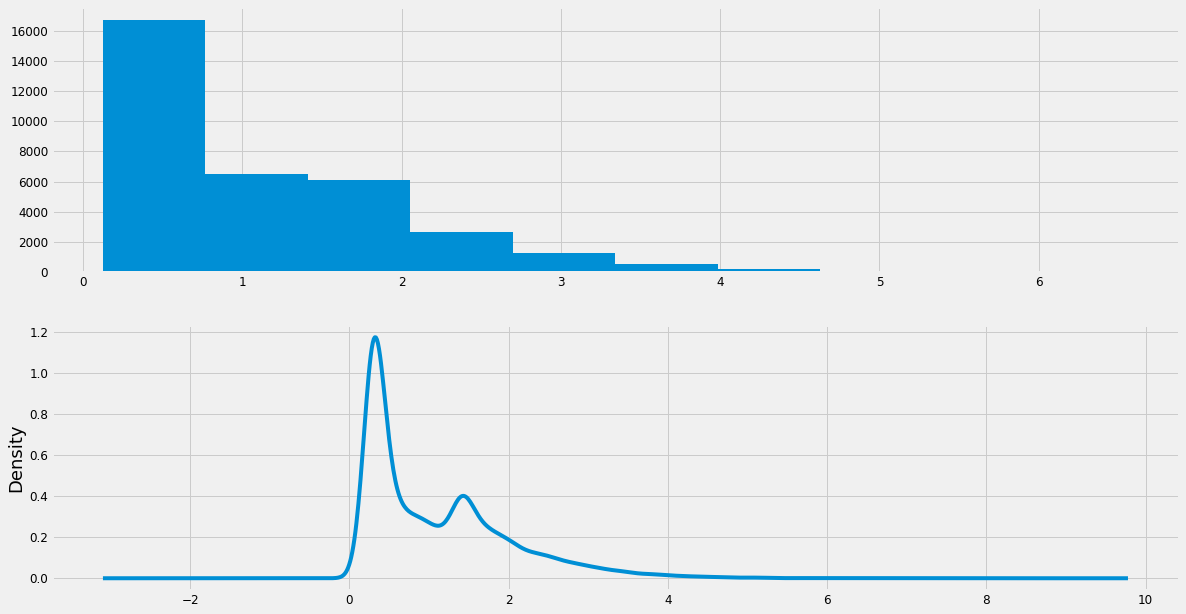

In [19]:
# Distribuição pela média da hora
plt.figure(1)

plt.subplot(211)
media_hor.hist()

plt.subplot(212)
media_hor.plot(kind='kde')
plt.show()

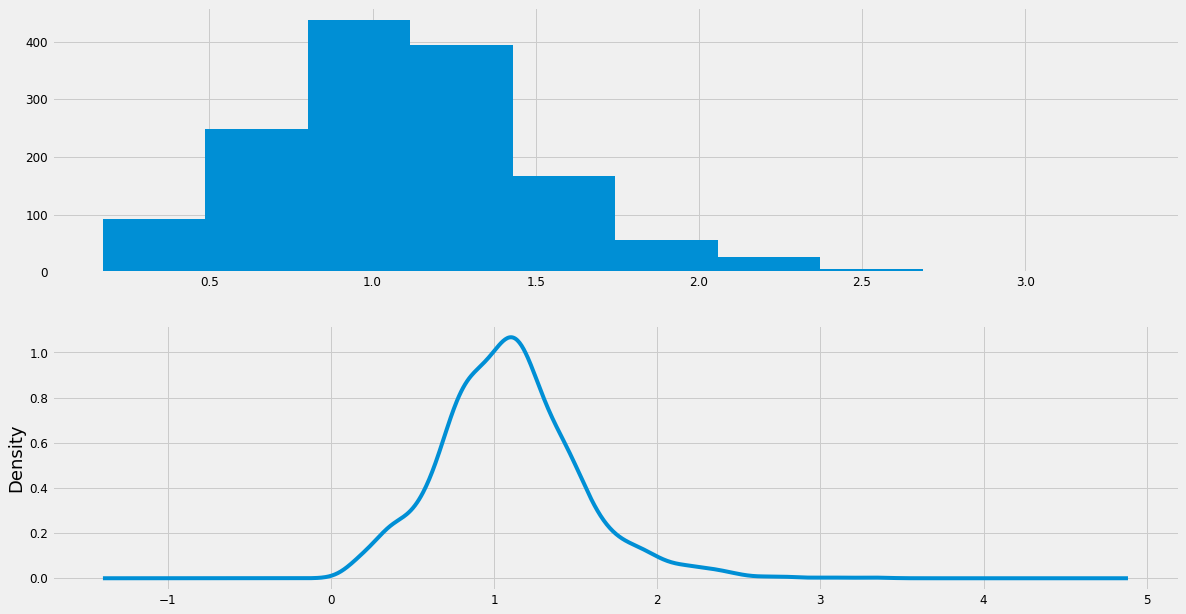

In [20]:
# Distribuição pela média do dia
plt.figure(1)

plt.subplot(211)
media_dia.hist()

plt.subplot(212)
media_dia.plot(kind='kde')
plt.show()

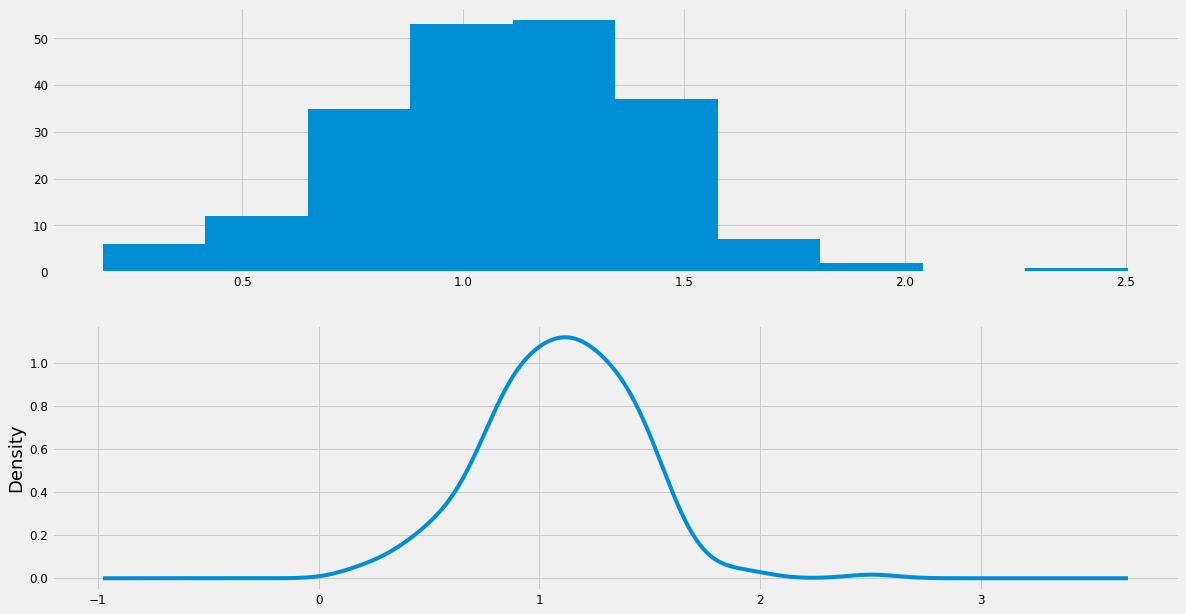

In [21]:
# Distribuição pela média da semana
plt.figure(1)

plt.subplot(211)
media_sem.hist()

plt.subplot(212)
media_sem.plot(kind='kde')
plt.show()

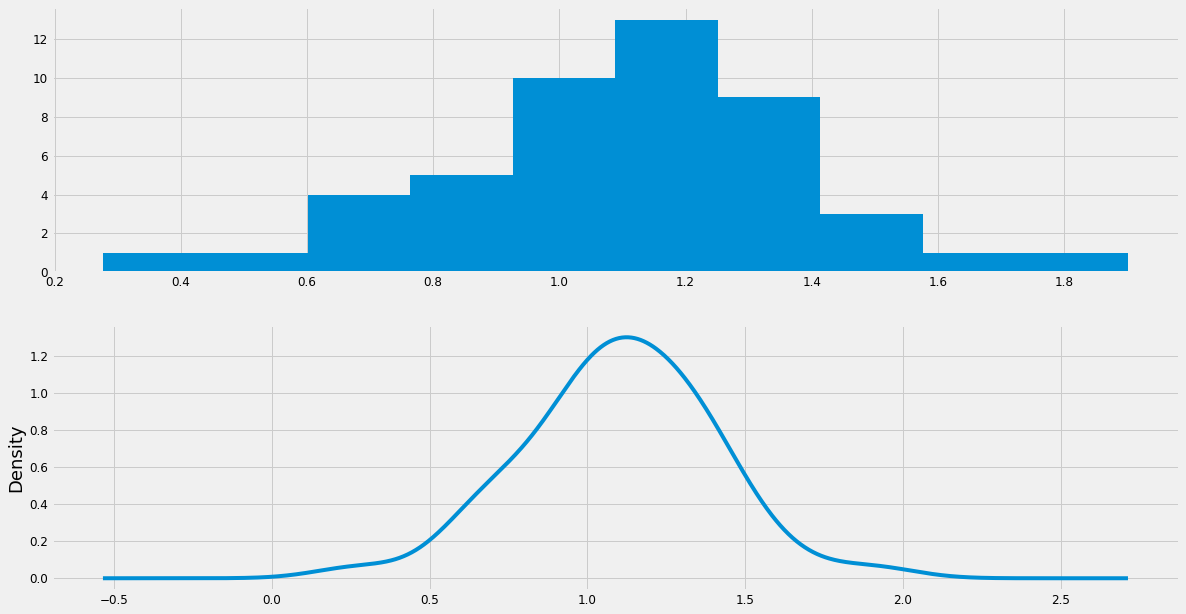

In [22]:
# Distribuição pela média do mês
plt.figure(1)

plt.subplot(211)
media_mes.hist()

plt.subplot(212)
media_mes.plot(kind='kde')
plt.show()

## Decomposição Multiplicativa

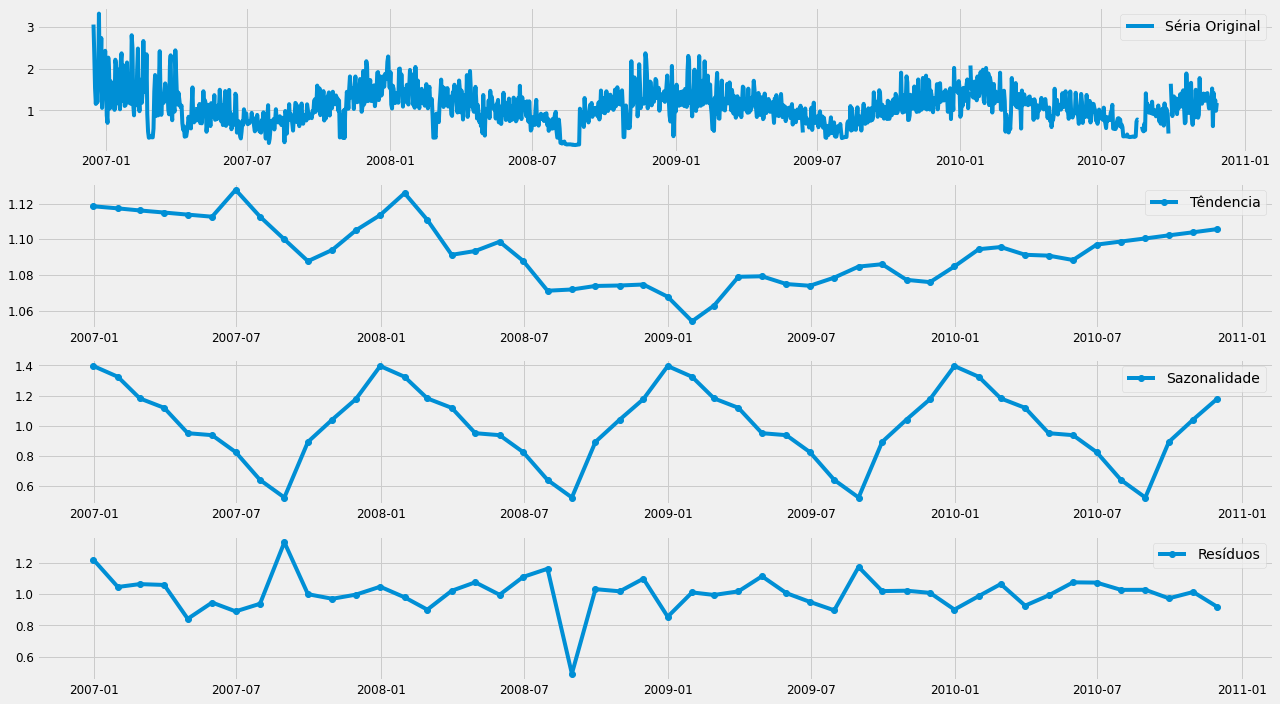

In [23]:
decomposicao = seasonal_decompose(media_mes, period=12, model='multiplicative', extrapolate_trend='freq')

trend = decomposicao.trend
seasonal = decomposicao.seasonal
residual = decomposicao.resid

plt.subplot(411)
plt.plot(media_dia, label='Séria Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, marker='o',label='Têndencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, marker='o',label='Sazonalidade')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, marker='o',label='Resíduos')
plt.legend(loc='best')
plt.tight_layout()

## Decomposição Aditiva

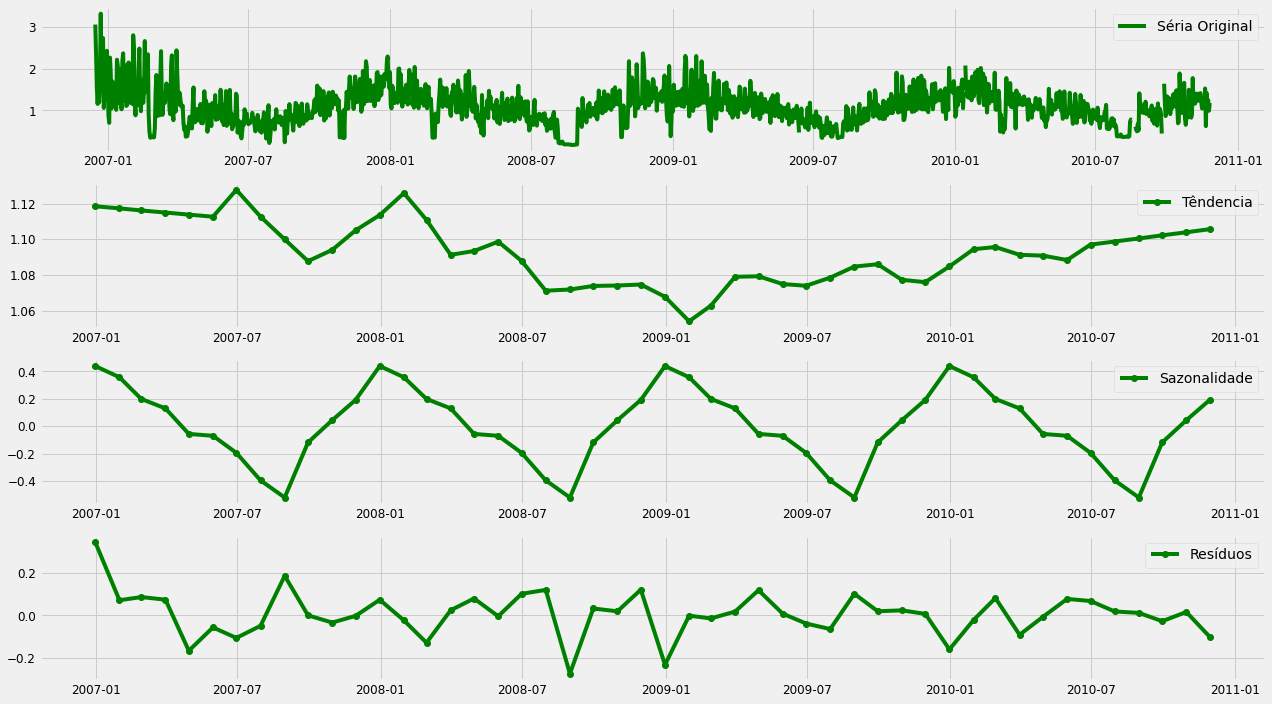

In [24]:
decomposicao = seasonal_decompose(media_mes, period=12, model='aditive', extrapolate_trend='freq')


trend = decomposicao.trend
seasonal = decomposicao.seasonal
residual = decomposicao.resid

plt.subplot(411)
plt.plot(media_dia, label='Séria Original', color='g')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, marker='o',label='Têndencia', color='g')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, marker='o',label='Sazonalidade', color='g')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, marker='o',label='Resíduos', color='g')
plt.legend(loc='best')
plt.tight_layout()

### Teste Dickey-Fuller

In [25]:
def testa_estacionaridade(dados):
    # Calcula estatísticas móveis
    rolmean = dados.rolling(window = 12).mean()
    rolstd = dados.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(dados, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()
    
    teste = adfuller(media_mes, autolag='AIC')

    saida = pd.Series(teste[0:4], index=['Estatística do Teste','Valor-p','Número de Lags Consideradas',
                                         'Número de Observações Usadas'])

    for key, value in teste[4].items():
        saida['Valor Crítico (%s)'%key] = value

    print(saida)

    if saida[1]> 0.05:
        print('\nSérie não estacionária.')
    else:
        print('\nSérie é estacionária')

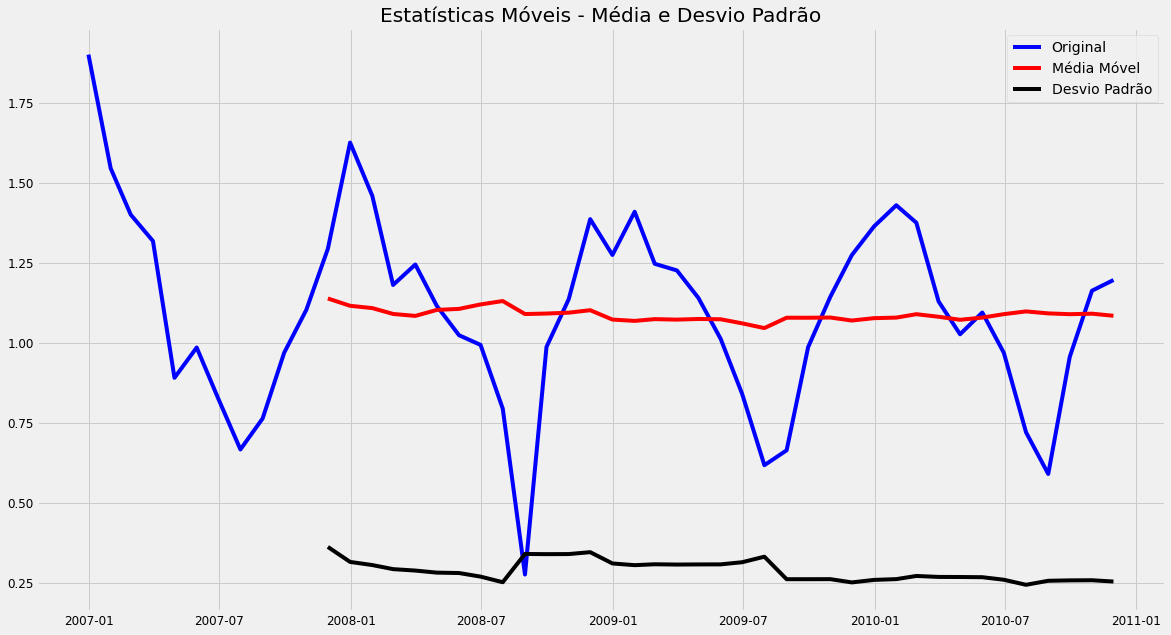

Estatística do Teste            -4.897270
Valor-p                          0.000035
Número de Lags Consideradas      9.000000
Número de Observações Usadas    38.000000
Valor Crítico (1%)              -3.615509
Valor Crítico (5%)              -2.941262
Valor Crítico (10%)             -2.609200
dtype: float64

Série é estacionária


In [26]:
testa_estacionaridade(media_mes)

### Removendo a sazonalidade

In [27]:
def preparandoDados(dados, interval=1):
    dif = []
    for i in range(interval, len(dados)):
        valor = dados[i] - dados[i - interval]
        dif.append(valor)
    return dif

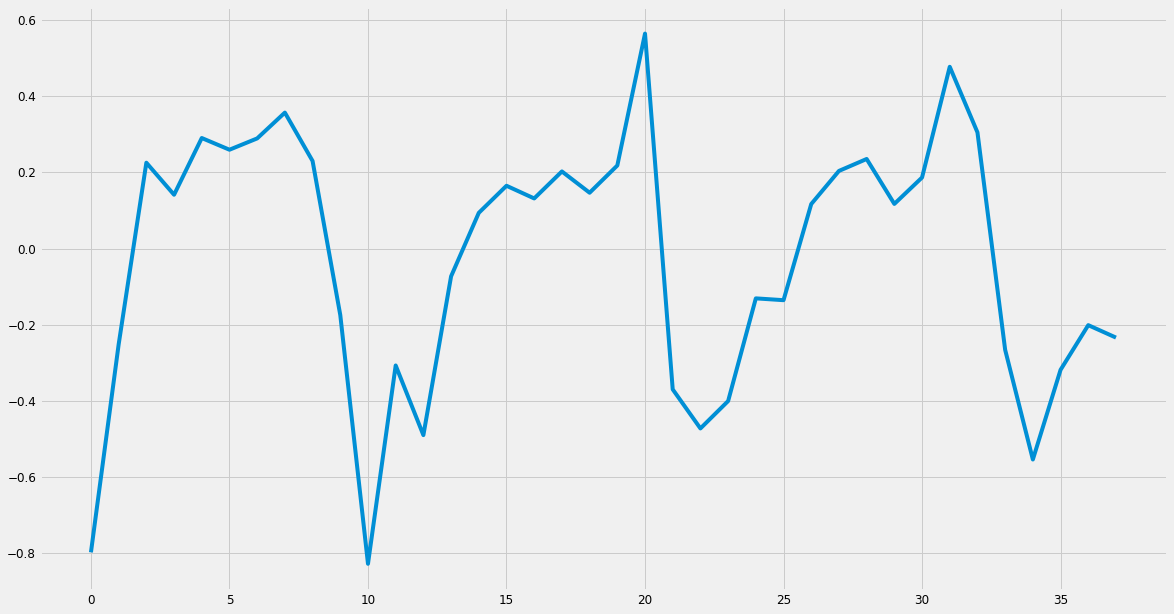

In [28]:
dados_dif = preparandoDados(media_mes, 10)
plt.plot(dados_dif)

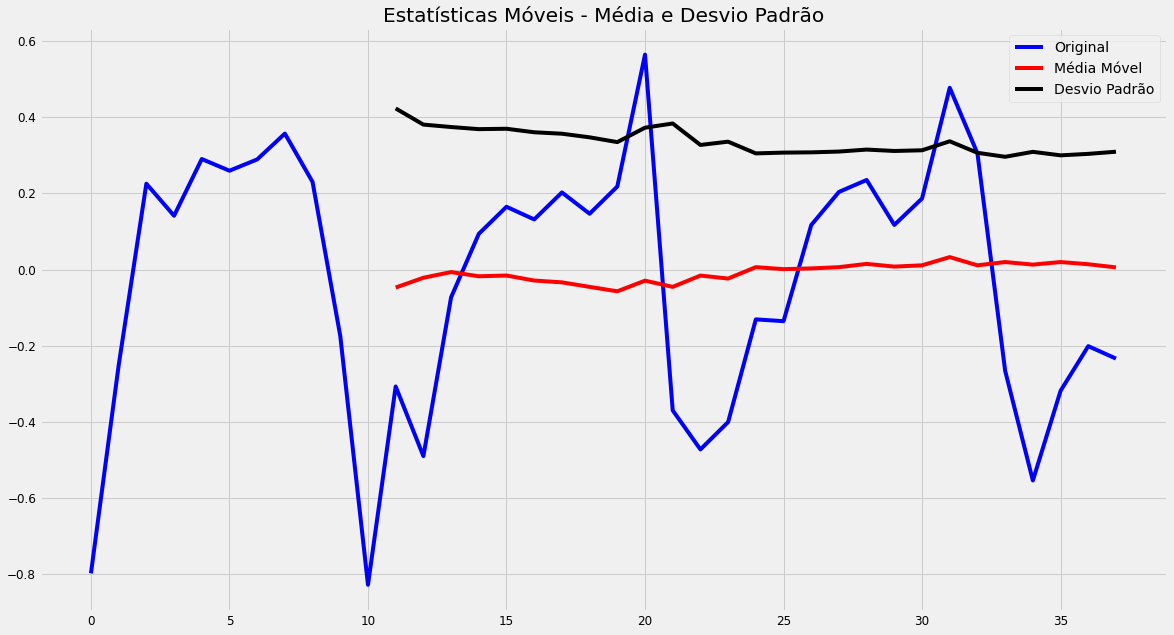

Estatística do Teste            -4.897270
Valor-p                          0.000035
Número de Lags Consideradas      9.000000
Número de Observações Usadas    38.000000
Valor Crítico (1%)              -3.615509
Valor Crítico (5%)              -2.941262
Valor Crítico (10%)             -2.609200
dtype: float64

Série é estacionária


In [29]:
dados_dif = pd.DataFrame(dados_dif)
testa_estacionaridade(dados_dif)

# Modelo Prophet

O Prophet é um modelo de série temporal que usa a tendência, sazonalidade e feriados como componenetes principais para fazer a previsão.

O Prophet é usado principalmente para dados diários e o conjunto de dados deve ter apenas duas colunas com seus nomes ds e y a coluna ds __sempre deve estar no formato data e hora(Datetime)'.__

__Parâmetros de Tendência__

- growth: 'linear' ou 'logistic' específica a tendência linear ou logística.
- changepoints:	Lista de datas nas quais incluir possíveis pontos de mudança (automático se não especificado).
- n_changepoints: Se os pontos de mudança não forem fornecidos, você poderá fornecer o número de pontos de mudança a serem incluídos automaticamente.
- changepoint_prior_scale: Parâmetro para alterar a flexibilidade da seleção automática de pontos de mudança.
 

__Parâmetros de Sazonalidade e Feriados__

- yearly_seasonality: Sazonalidade anual.
- weekly_seasonality: Sazonalidade semanal.
- daily_seasonality: Sazonalidade diária.
- holidays: Dataframe contendo nome e data do feriado.
- seasonality_prior_scale: Parâmetro para alterar a força do modelo de sazonalidade.
- holiday_prior_scale: Parâmetro para alterar a força do modelo de feriados.


__X e Y__

O Prophet exige que os nomes de variáveis na série temporal sejam:

- y – Target
- ds – Datetime

In [30]:
type(media_dia)

pandas.core.series.Series

In [31]:
treino = media_dia.iloc[0:-30]
teste = media_dia.iloc[-30:]

In [32]:
treino = pd.DataFrame({'data':treino.index,'valor':treino.values})
teste = pd.DataFrame({'data':teste.index,'valor':teste.values})

In [33]:
treino = treino.rename(columns={'data':'ds', 'valor':'y'})
teste = treino.rename(columns={'data':'ds', 'valor':'y'})

In [34]:
model = Prophet(interval_width=0.95, yearly_seasonality=True)
model.fit(treino)
previsao = model.make_future_dataframe(periods=30, freq='D')
previsao.count()

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds    1442
dtype: int64

In [35]:
# Forecast
prev = model.predict(previsao)
prev[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1437,2010-11-22,1.382330,0.780275,1.952439
1438,2010-11-23,1.465762,0.904394,2.019067
1439,2010-11-24,1.477043,0.920089,2.034200
1440,2010-11-25,1.375470,0.846366,1.900276
1441,2010-11-26,1.436007,0.891296,2.010755


In [36]:
prev.drop(columns = ['multiplicative_terms', 
                                        'multiplicative_terms_lower',
                                        'multiplicative_terms_upper'], inplace = True)

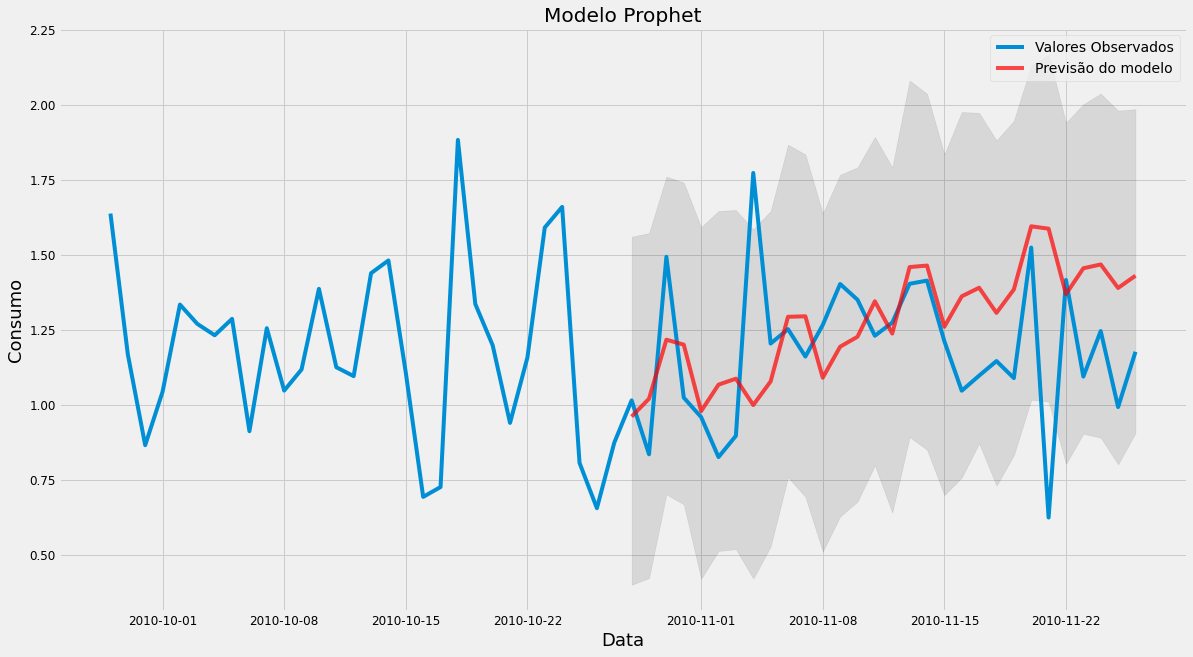

In [59]:
# Série Original
plt.plot(media_dia[-60:].index, media_dia[-60:].values, label='Valores Observados')

# Previsão
plt.plot(media_dia[-30:].index, prev[-30:]['yhat'].values, label='Previsão do modelo',alpha=0.7, color='red')

# Intervalo de confiança
plt.fill_between(media_dia[-30:].index, prev[-30:]['yhat_lower'].values, prev[-30:]['yhat_upper'].values,
                color='k',alpha=0.1)

plt.title('Modelo Prophet')
plt.legend(loc='best')
plt.xlabel('Data')
plt.ylabel('Consumo')
plt.savefig('Plots_serie/prophet.png')
plt.show()

# Trabalhando com feriado

In [38]:
model = Prophet(interval_width=0.95, daily_seasonality=True)
model.add_country_holidays(country_name='US')
model.fit(treino)
previsao = model.make_future_dataframe(periods=30, freq='D')
previsao.count()

ds    1442
dtype: int64

In [39]:
prev = model.predict(previsao)

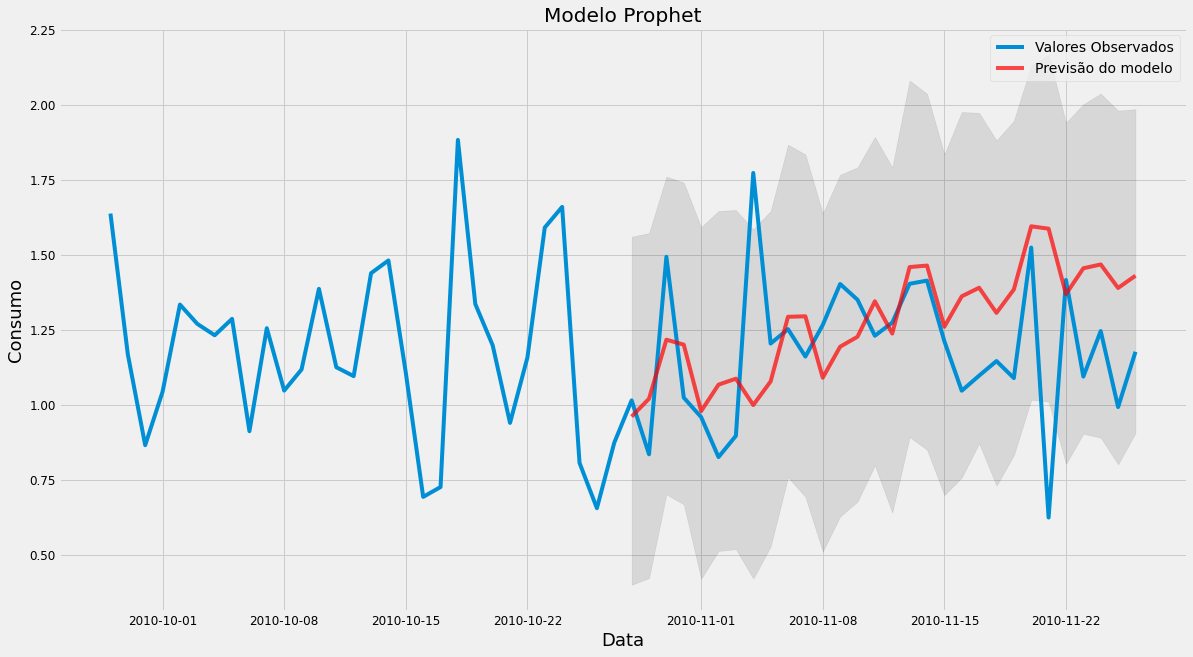

In [58]:
# Série Original
plt.plot(media_dia[-60:].index, media_dia[-60:].values, label='Valores Observados')

# Previsão
plt.plot(media_dia[-30:].index, prev[-30:]['yhat'].values, label='Previsão do modelo',alpha=0.7, color='red')

# Intervalo de confiança
plt.fill_between(media_dia[-30:].index, prev[-30:]['yhat_lower'].values, prev[-30:]['yhat_upper'].values,
                color='k',alpha=0.1)

plt.title('Modelo Prophet')
plt.legend(loc='best')
plt.xlabel('Data')
plt.ylabel('Consumo')
plt.savefig('Plots_serie/prophet_feriado.png')
plt.show()

# Redes Neurais Recorrentes - LSTM (Long Short-Term Memor)

Redes Neuras do tipo recorrentes são ótimas para trabalharmos com dados em sequência. A LSTM utiliza o Backpropagation Through Time para superar a dissipação do gradiente. O modelo por ser usado para resolver problemas em sequência. A rede possui blocos de memória conectados que difere das outras redes que possuem neuronios matematicos. Seus blocos contem portões que gerenciam o estado da rede.

São 3 tipos de portões:
* Forget Gate: Portão do esquecimento
* Input Gate: Portão de entrada
* Output Gate: Portão de sáida

In [41]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler

### Separando os dados de treino e teste

In [42]:
media_dia.dropna(inplace=True)

In [43]:
treino = media_dia.iloc[0:-30]
teste = media_dia.iloc[-30:]

### Colocandos os dados no formato que a rede precisa

In [44]:
treino, teste = np.array(treino[0:-30]), np.array(teste[-30:])
treino = treino.reshape(-1,1)
teste = teste.reshape(-1,1)

In [45]:
treino = treino.astype('float32')
teste = teste.astype('float32')

scaler = MinMaxScaler()
scaler.fit(treino)
treino = scaler.transform(treino)

scaler = MinMaxScaler()
scaler.fit(teste)
teste = scaler.transform(teste)

### Hiperparâmetros para a rede neural

In [46]:
epochs = 300

entrada = 30

saida = 30

features = 1

batch = 30

In [47]:
generator = TimeseriesGenerator(treino, treino, length=saida, batch_size=batch)

In [48]:
model = Sequential()
model.add(Bidirectional(LSTM(60, activation='relu', input_shape=(entrada,features))))
model.add(Dense(50, activation='relu'))
model.add(Dense(30))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit_generator(generator,epochs=epochs)

Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/300
45/45 [==============================] - 1s 31ms/step - loss: 0.0536
Epoch 2/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0125
Epoch 3/300
45/45 [==============================] - 1s 31ms/step - loss: 0.0114
Epoch 4/300
45/45 [==============================] - 1s 31ms/step - loss: 0.0111
Epoch 5/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0113
Epoch 6/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0108
Epoch 7/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0105
Epoch 8/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0108
Epoch 9/300
45/45 [==============================] - 1s 31ms/step - loss: 0.0101
Epoch 10/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0104
Epoch 11/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0099
Epoch 12/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0099
Epoch 13/300
45/45 [=====

45/45 [==============================] - 1s 31ms/step - loss: 0.0079
Epoch 102/300
45/45 [==============================] - 1s 31ms/step - loss: 0.0079
Epoch 103/300
45/45 [==============================] - 1s 31ms/step - loss: 0.0081
Epoch 104/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0082
Epoch 105/300
45/45 [==============================] - 1s 31ms/step - loss: 0.0080
Epoch 106/300
45/45 [==============================] - 1s 31ms/step - loss: 0.0080
Epoch 107/300
45/45 [==============================] - 1s 31ms/step - loss: 0.0079
Epoch 108/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0078
Epoch 109/300
45/45 [==============================] - 1s 31ms/step - loss: 0.0078
Epoch 110/300
45/45 [==============================] - 1s 31ms/step - loss: 0.0078
Epoch 111/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0077
Epoch 112/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0079
Epoch 113/300
45/4

45/45 [==============================] - 1s 32ms/step - loss: 0.0049
Epoch 298/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0049
Epoch 299/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0049
Epoch 300/300
45/45 [==============================] - 1s 32ms/step - loss: 0.0050


In [49]:
valor_prever = np.array(media_dia.iloc[-60:-30])
valor_prever = valor_prever.reshape(1,entrada,features)
previsao = model.predict(valor_prever)
previsao = scaler.inverse_transform(previsao)
previsao = previsao.flatten()

In [50]:
vl_real = np.array(media_dia.iloc[-30:])

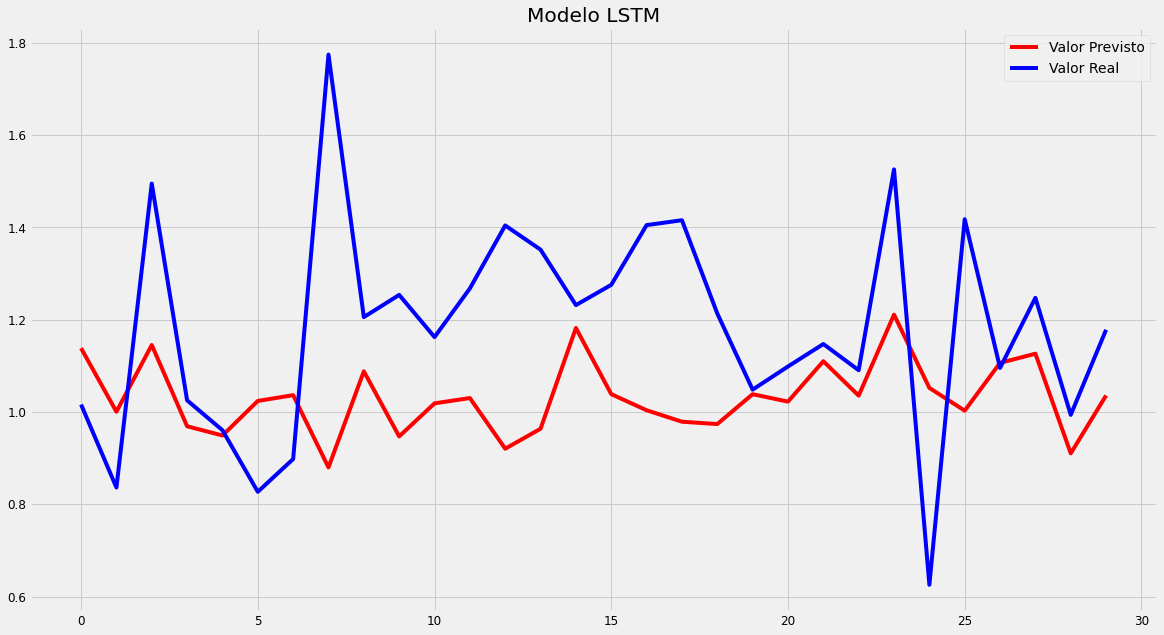

In [51]:
plt.plot(previsao, label='Valor Previsto', color='red')
plt.plot(vl_real, label='Valor Real', color='blue')
plt.title('Modelo LSTM')
plt.legend(loc='best')
plt.savefig('Plots_serie/lstm.png')
plt.show()

# GRU

In [52]:
from keras.layers import GRU

In [53]:
model = Sequential()
model.add(Bidirectional(GRU(90, activation='relu', input_shape=(entrada,features))))
model.add(Dense(30))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit_generator(generator,epochs=epochs)

Epoch 1/300
45/45 [==============================] - 2s 43ms/step - loss: 0.0357
Epoch 2/300
45/45 [==============================] - 2s 43ms/step - loss: 0.0128
Epoch 3/300
45/45 [==============================] - 2s 43ms/step - loss: 0.0111
Epoch 4/300
45/45 [==============================] - 2s 41ms/step - loss: 0.0101
Epoch 5/300
45/45 [==============================] - 2s 44ms/step - loss: 0.0097
Epoch 6/300
45/45 [==============================] - 2s 43ms/step - loss: 0.0093
Epoch 7/300
45/45 [==============================] - 2s 42ms/step - loss: 0.0096
Epoch 8/300
45/45 [==============================] - 2s 43ms/step - loss: 0.0092
Epoch 9/300
45/45 [==============================] - 2s 43ms/step - loss: 0.0091
Epoch 10/300
45/45 [==============================] - 2s 41ms/step - loss: 0.0090
Epoch 11/300
45/45 [==============================] - 2s 43ms/step - loss: 0.0090
Epoch 12/300
45/45 [==============================] - 2s 42ms/step - loss: 0.0089
Epoch 13/300
45/45 [=====

45/45 [==============================] - 2s 46ms/step - loss: 0.0071
Epoch 102/300
45/45 [==============================] - 2s 44ms/step - loss: 0.0073
Epoch 103/300
45/45 [==============================] - 2s 42ms/step - loss: 0.0071
Epoch 104/300
45/45 [==============================] - 2s 43ms/step - loss: 0.0071
Epoch 105/300
45/45 [==============================] - 2s 43ms/step - loss: 0.0070
Epoch 106/300
45/45 [==============================] - 2s 42ms/step - loss: 0.0071
Epoch 107/300
45/45 [==============================] - 2s 42ms/step - loss: 0.0070
Epoch 108/300
45/45 [==============================] - 2s 43ms/step - loss: 0.0069
Epoch 109/300
45/45 [==============================] - 2s 43ms/step - loss: 0.0070
Epoch 110/300
45/45 [==============================] - 2s 43ms/step - loss: 0.0070
Epoch 111/300
45/45 [==============================] - 2s 43ms/step - loss: 0.0070
Epoch 112/300
45/45 [==============================] - 2s 43ms/step - loss: 0.0070
Epoch 113/300
45/4

45/45 [==============================] - 2s 42ms/step - loss: 0.0047
Epoch 298/300
45/45 [==============================] - 2s 41ms/step - loss: 0.0043
Epoch 299/300
45/45 [==============================] - 2s 42ms/step - loss: 0.0042
Epoch 300/300
45/45 [==============================] - 2s 41ms/step - loss: 0.0046


In [54]:
valor_prever = np.array(media_dia.iloc[-60:-30])
valor_prever = valor_prever.reshape(1,entrada,features)
previsao = model.predict(valor_prever)
previsao = scaler.inverse_transform(previsao)
previsao = previsao.flatten()

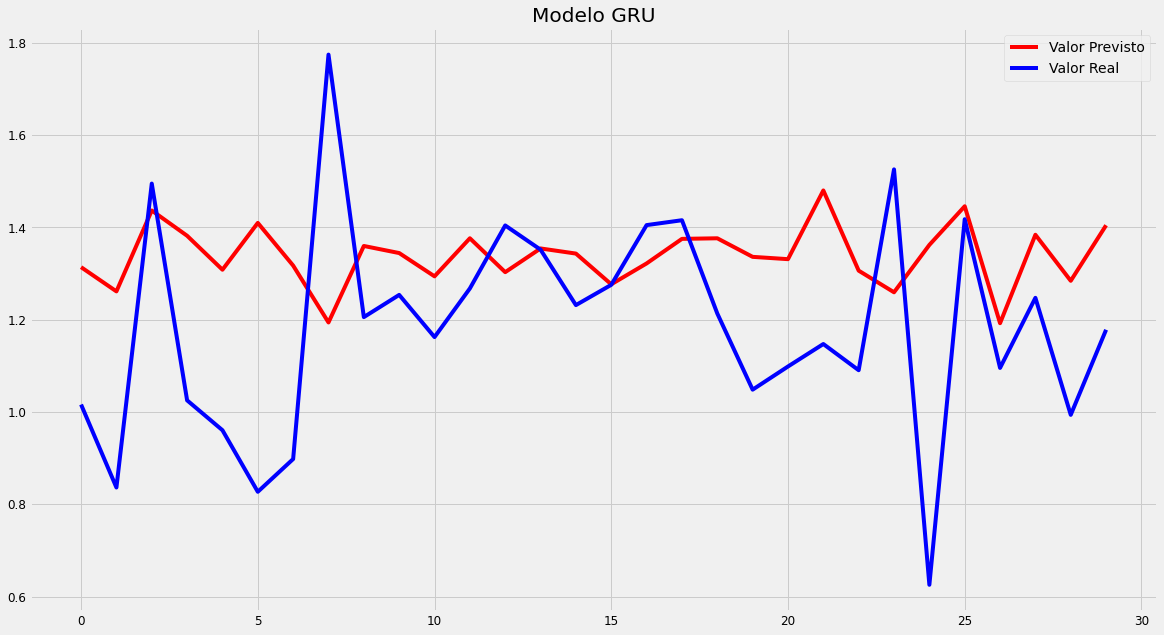

In [56]:
plt.plot(previsao, label='Valor Previsto', color='red')
plt.plot(vl_real, label='Valor Real', color='blue')
plt.title('Modelo GRU')
plt.legend(loc='best')
plt.savefig('Plots_serie/gru.png')
plt.show()